# Volume 4: Spectral 1
    Daniel Perkins
    MATH 439
    1/7/25

In [59]:
import numpy as np
from matplotlib import pyplot as plt
from scipy.interpolate import barycentric_interpolate
from numpy import linalg as la
from scipy.optimize import root

%matplotlib inline

# Setup

In [60]:
def cheb(N):
    x = np.cos((np.pi/N)*np.linspace(0, N, N+1))
    x.shape = (N+1, 1)
    lin = np.linspace(0, N, N+1)
    lin.shape = (N+1, 1)
    
    c = np.ones((N+1, 1))
    c[0], c[-1] = 2., 2.
    c = c*(-1.)**lin
    X = x*np.ones(N+1) # Broadcast along 2nd dimension (columns)
    
    dX = X - X.T
    
    D = (c*(1./c).T)/(dX + np.eye(N+1))
    D = D - np.diag(np.sum(D.T, axis=0))
    x.shape = (N+1,)
    # Here we return the differentiation matrix and the Chebyshev points,
    # numbered from x_0 = 1 to x_N = -1
    return D[::-1, ::-1], x[::-1]

# Problem 1

Use the differentiation matrix to numerically approximate the derivative of u(x)) on a grid of N Chebychev points where N = 6, 8, and 10.
Then use barycentric interpolation (scipy.interpolate.barycentric_interpolate) to
approximate u0 on a grid of 100 evenly spaced points.
Graphically compare your approximation to the exact derivative

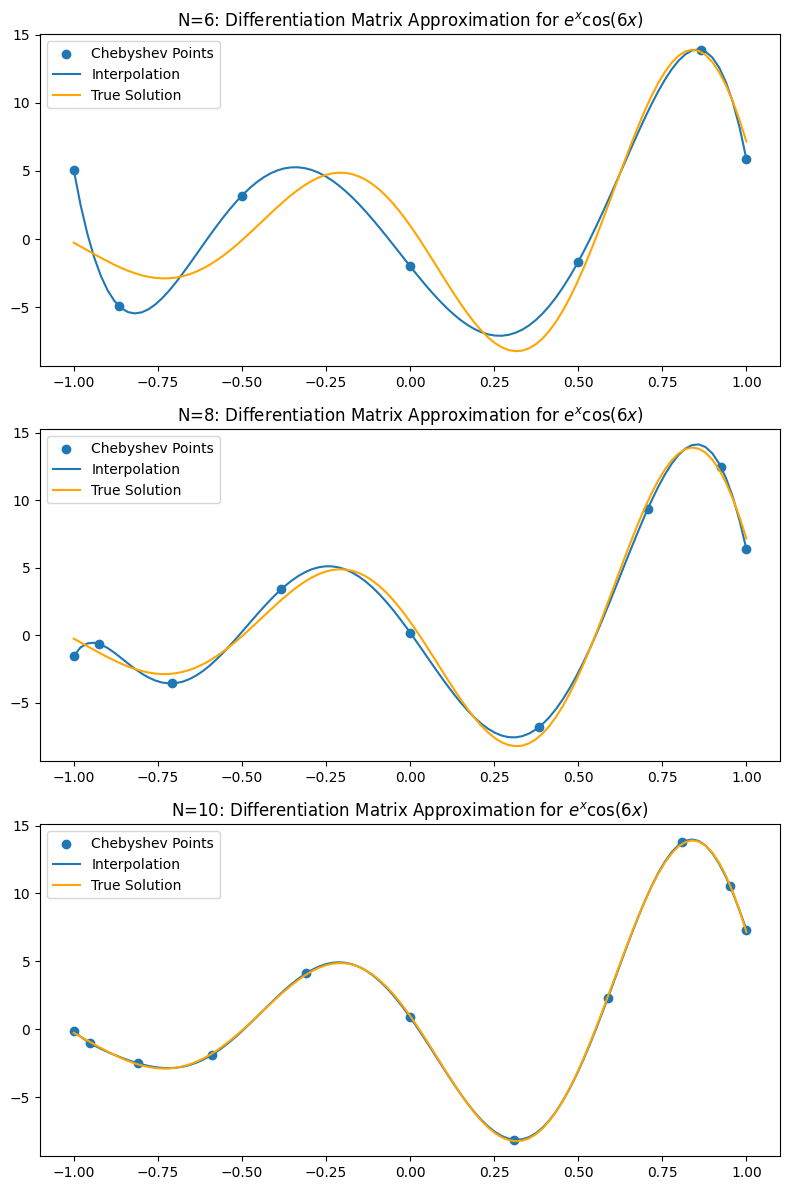

In [30]:
# Initialize things
x_space = np.linspace(-1, 1, 100)
Ns = [6, 8, 10]
xs = []
Fs = []
Interpolations = []

for N in Ns:
    # Define function, D matrix and Chebyshev points
    u = lambda x: np.exp(x)*np.cos(6*x)
    D, x = cheb(N)

    # Calculate derivative using D matrix
    U = u(x)
    F = D @ U
    
    # Barycentric interpolation
    Interpolation = barycentric_interpolate(x, F, x_space)
    
    # Store things
    xs.append(x)
    Fs.append(F)
    Interpolations.append(Interpolation)

    

# Define true derivative
u_prime = lambda x: -6*np.exp(x)*np.sin(6*x) + np.exp(x)*np.cos(6*x)
u_prime = u_prime(x_space)

# Plot it
plt.figure(figsize=(8,12))
for i, N in enumerate(Ns):
    plt.subplot(3, 1, i+1)
    plt.title(fr"N={N}: Differentiation Matrix Approximation for $e^x\cos(6x)$")
    plt.scatter(xs[i], Fs[i], label="Chebyshev Points")
    plt.plot(x_space, Interpolations[i], label="Interpolation")
    plt.plot(x_space, u_prime, label="True Solution", color="Orange")
    plt.legend()
    
plt.tight_layout()
plt.show()


# Problem 2

Use the pseudospectral method to solve the boundary value problem.
Use N = 8 in the cheb(N) method and use barycentric interpolation to approximate u on
100 evenly spaced points. Compare your numerical solution with the exact solution.

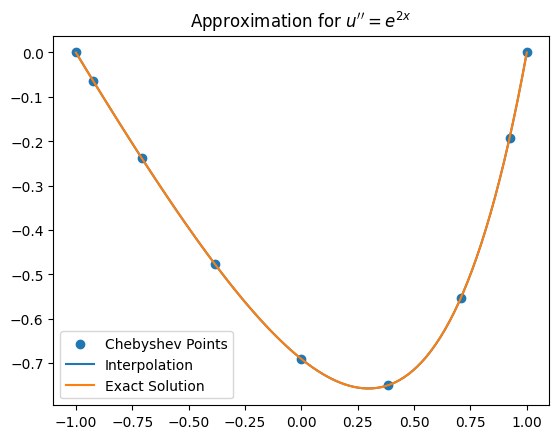

In [31]:
# Set variables
N = 8
u_prime_prime = lambda x: np.exp(2*x)
x_space = np.linspace(-1, 1, 100)

# Get D2 and Chebyshev points (formula 14.3 and yellow box below)
D, x = cheb(N)
U = u_prime_prime(x)
D2 = np.dot(D, D)
D2[0, :], D2[-1, :] = 0, 0
D2[0, 0], D2[-1, -1] = 1, 1

# Right-hand side
U = u_prime_prime(x)  # Evaluate u'' = e^(2x) at Chebyshev points
F = np.copy(U)
F[0], F[-1] = 0, 0  # Boundary conditions for F

# Solve for u at Chebyshev points
u = np.linalg.solve(D2, F)

# Get interpolation
Interpolation = barycentric_interpolate(x, u, x_space)

# Define solution
def solution_formula(x):
    num = -np.cosh(2) - np.sinh(2)*x + np.exp(2*x)
    return num / 4
solution = solution_formula(x_space)

# Plot it
plt.title(r"Approximation for $u''=e^{2x}$")
plt.scatter(x, u, label="Chebyshev Points")
plt.plot(x_space, Interpolation, label="Interpolation")
plt.plot(x_space, solution, label="Exact Solution")
plt.legend()
plt.show()

# Problem 3

Use the pseudospectral method to solve the boundary value problem.
Use N = 8 in the cheb(N) method and use barycentric interpolation to approximate u on
100 evenly spaced points.

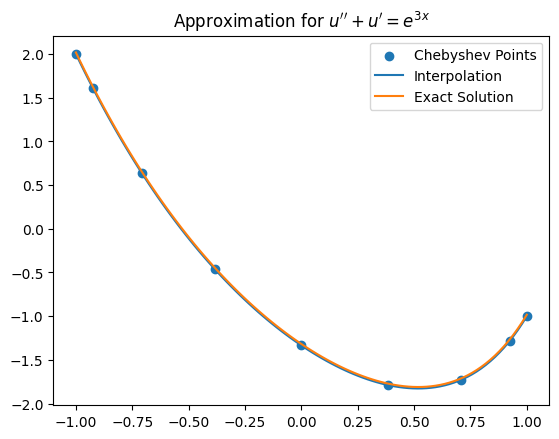

In [65]:
# Set variables
N = 8
f = lambda x: np.exp(3*x)
x_space = np.linspace(-1, 1, 100)

# Get D2 and Chebyshev points (formula 14.3 and yellow box below)
D, x = cheb(N)
D2 = np.dot(D, D)
left = D2 + D  # Add u'' + u'
U = f(x)
left[0, :], left[-1, :] = 0, 0
left[0, 0], left[-1, -1] = 1, 1

# Right-hand side
F = np.copy(U)
F[0], F[-1] = 2, -1  # Boundary conditions for F

# Solve for u at Chebyshev points
u = np.linalg.solve(left, F)

# Get interpolation
Interpolation = barycentric_interpolate(x, u, x_space)

analytic_solution = lambda x: (np.exp(-2-x) - 36*np.exp(1-x) - np.exp(4-x) + np.exp(3*x) -\
    np.exp(3*x+2) + 24 - (1/np.exp(3)) + 12*np.exp(2) + 5*np.exp(5)) \
        /(12 - 12*np.exp(2)) +7.76
solution = analytic_solution(x_space)

# Plot it
plt.title(r"Approximation for $u''+u'=e^{3x}$")
plt.scatter(x, u, label="Chebyshev Points")
plt.plot(x_space, Interpolation, label="Interpolation")
plt.plot(x_space, solution, label="Exact Solution")
plt.legend()
plt.show()

# Problem 4

Use the pseudospectral method to solve the boundary value problem
for several values of λ: λ = 4, 8, 12. Begin by transforming this BVP onto the domain −1 <
x < 1. Use N = 20 in the cheb(N) method and use barycentric interpolation to approximate
u on 100 evenly spaced points

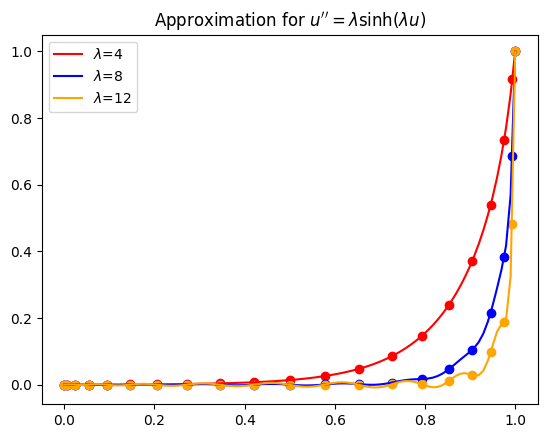

In [33]:
# Set variables
N = 20
colors = ["red", "blue", "orange"]

for i, lam in enumerate([4, 8, 12]):
    # Get D2 and Chebyshev points (formula 14.3 and yellow box below)
    D, x = cheb(N)
    D2 = np.dot(D, D)
    D2[0, :], D2[-1, :] = 0, 0  
    D2[0, 0], D2[-1, -1] = 1, 1
    x = (x+1) / 2  # Shift domain
    
    # Define function
    def F(U):
        F = lam*np.sinh(lam*U)
        F[0], F[-1] = 0, 1  # Boundary conditions for F
        return D2 @ U - F
    x_space = np.linspace(0, 1, 100)

    # Get U
    guess = np.ones_like(x).astype(float)
    u = root(F, guess).x   

    # Get interpolation
    Interpolation = barycentric_interpolate(x, u, x_space)

    # Plot it
    plt.scatter(x, u, color=colors[i])
    plt.plot(x_space, Interpolation, color=colors[i], label=rf"$\lambda$={lam}")
    plt.legend()

plt.title(r"Approximation for $u''=\lambda \sinh(\lambda u)$")
plt.show()

# Problem 5

Find the function y(x) that satisies y(−1) = 1, y(1) = 7, and whose surface of
revolution (about the x-axis) minimizes surface area. Compute the surface area, and plot the
surface. Use N = 50 in the cheb(N) method and use barycentric interpolation to approximate
u on 100 evenly spaced points.
Below is sample code for creating the 3D wireframe figure.

The Surface area is 158.53594756998106


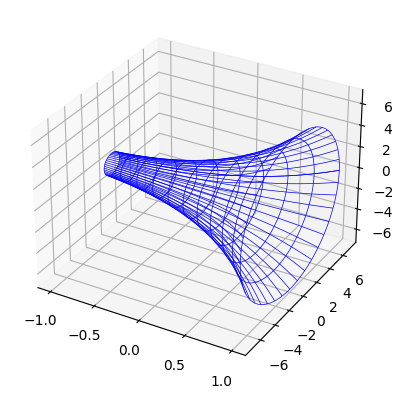

In [87]:
# Set variables
N = 50
D, x = cheb(N)
D2 = np.dot(D, D)

D2[0, :], D2[-1, :] = 0, 0  
D2[0, 0], D2[-1, -1] = 1, 1
# Define function
def F(Y):
    DY = D @ Y
    D2Y = D2 @ Y
    out = Y*D2Y - DY*DY - 1
    out[0], out[-1] = Y[0]-1, Y[-1]-7 # Boundary conditions
    return out

# Get u
guess = 2*np.ones_like(x).astype(float)
u = root(F, guess).x   

# Get interpolation
x_space = np.linspace(-1, 1, 100)
barycentric = barycentric_interpolate(x, u, x_space)

# Compute surface area
dy = np.diff(barycentric)
dx = np.diff(x_space)
dy_dx = dy / dx
surface_area = 2*np.pi*np.sum(barycentric[1:] * np.sqrt(1+dy_dx**2)*dx)
print("The Surface area is", surface_area)

# This code was given
lin = np.linspace(-1, 1, 100)
theta = np.linspace(0, 2*np.pi, 401)
X, T = np.meshgrid(lin, theta)
Y, Z = barycentric*np.cos(T), barycentric*np.sin(T)
fig = plt.figure()
ax = fig.add_subplot(projection='3d')
ax.plot_wireframe(X, Y, Z, color='b', rstride=10, cstride=10, lw=0.5)
plt.show()